# Neural Networks with TensorFlow and Keras

Deep neural networks tend to be massive with dozens or even hundreds of layers, that's where the term "deep" comes from. You can build one of these deep networks using only weight matrices as we did in the previous notebook, but in general it's very cumbersome and difficult to implement. TensorFlow has a nice API called **Keras** that provides a nice way to efficiently build large neural networks.

## Import Resources

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [5]:
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.6.2
	• tf.keras version: 2.6.0
	• GPU device not found. Running on CPU


## Load the Dataset

Now we're going to build a larger network that can solve a (formerly) difficult problem, identifying text in an image. Here we'll use the MNIST dataset which consists of greyscale handwritten digits. Each image is 28x28 pixels, you can see a sample below

<img src='assets/mnist.png'>

Our goal is to build a neural network that can take one of these images and predict the digit in the image.

First up, we need to get the dataset we are going to use to train and test our Neural Network. We will get our dataset using the [`tensorflow_datasets`](https://www.tensorflow.org/datasets) package. TensorFlow Datasets is a repository of datasets ready to use with TensorFlow. TensorFlow Datasets has a wide variety of datasets to train your machine learning models for many different tasks, ranging from text to video. For a full list of the datasets available in TensorFlow Datasets check out the [TensorFlow Datasets Catalog](https://www.tensorflow.org/datasets/catalog/overview#all_datasets).


The code below will load the MNIST dataset. 

In [6]:
# Load training data
'''
1. We can define what feature we expect : in te first place we need to define the name of dataset, 
 
2. In the second place we need to define which part of data we need, for example here we mention ok
we want 'train set',

3. In the next place we mentioned that "supervised = true" means it returns the label of each data.

4. and in the last part we define we need some information about the dataset features.

5. OUTPUT:so we have two output: training_set and dataset_info

'''

training_set, dataset_info = tfds.load('mnist', split = 'train', as_supervised = True, with_info = True)

In [7]:
dataset_info.description

'The MNIST database of handwritten digits.'

In [8]:
dataset_info.full_name

'mnist/3.0.1'

In [17]:
dataset_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='C:\\Users\\1234\\tensorflow_datasets\\mnist\\3.0.1',
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

## Inspect the Dataset

We have loaded the training data into `training_set` and loaded dataset information into `dataset_info`.  Let's get the total number of classes and the total number of images in our training set from `dataset_info`.

In [18]:
num_classes = dataset_info.features['label'].num_classes
print('There are {:,} classes in our dataset'.format(num_classes))

num_training_examples = dataset_info.splits['train'].num_examples
print('\nThere are {:,} images in the training set'.format(num_training_examples))

There are 10 classes in our dataset

There are 60,000 images in the training set


We can use `training_set` as an iterator so, we can use the following statement to loop through the dataset:

```python
for image, label in training_set:
    ## do things with images and labels
```

Let's print the shape and dtype of our images and labels. We'll use the `.take(1)` method to only choose one element from our dataset. Since our dataset consists of images, the `.take(1)` method will choose only one image. 

In [19]:
training_set.take(1)

<TakeDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>

In [20]:
# .take(2) consider two images. we can see different images by using different numbers in take(number)
# image and label are both tensor
for image, label in training_set.take(1):
    print('The images in the training set have:')
    print('\u2022 dtype:', image.dtype) 
    print('\u2022 shape:', image.shape)
  
    print('\nThe labels of the images have:')
    print('\u2022 dtype:', label.dtype) 
    print('\n --------------------')

The images in the training set have:
• dtype: <dtype: 'uint8'>
• shape: (28, 28, 1)

The labels of the images have:
• dtype: <dtype: 'int64'>

 --------------------


The images in our dataset are tensors of `shape = (28, 28, 1)` and `dtype = uint8`. `unit8` represents an 8-bit unsigned integer and can hold integers in the range 0 to 255. On the other hand, the labels of our images are tensors of `dtype = int64`, which means they are 64-bit signed integers. Now let's see what an image from our dataset looks like. In order to plot our images, we will have to convert them from TensorFlow tensors to NumPy ndarrays first, by using the `.numpy()` method. Since the images have `shape = (28, 28, 1)` we will use the `.squeeze()` method to reshape the images to have `shape = (28, 28)`. The `.squeeze()` method removes single-dimensional entries from the shape of an ndarray.

In [23]:
label.shape

TensorShape([])

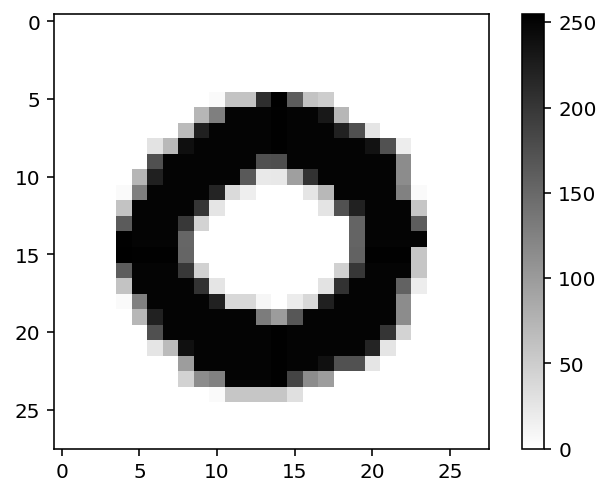

The label of this image is: 0


In [8]:
for image, label in training_set.take(1):
    image = image.numpy().squeeze() # image and label are both tensor and we need to change their type to numpy first here
    label = label.numpy()
    
# Plot the image
plt.imshow(image, cmap = plt.cm.binary) # binary color becuase we are ploting in gray scale.
plt.colorbar()
plt.show()
# pay attention the scale of the plot in the x axis and y axis is 28 by 28 and the gray scale is from 0 to 255
# in the next part when we do normalization you will see this scale will change 
print('The label of this image is:', label)

## Create Pipeline

As we can see, the pixel values of our images are in the range `[0, 255]`. We will now normalize the images and create a pipeline with our training set so that it can be fed into our neural network. In order to normalize the images we are going to divide the pixel values by 255. We will therefore, first change the `dtype` of our image from `uint8` to `float32`  (32-bit single-precision floating-point numbers) using the `tf.cast` function.

In [9]:
# Create Pipeline: means do some transformation on data that help them be prepared to feed into neural network.
def normalize(image, label):
    image = tf.cast(image, tf.float32) #tf.cast help to change the datatype.
    image /= 255
    return image, label

batch_size = 64

training_batches = training_set.cache().shuffle(num_training_examples//4).batch(batch_size).map(normalize).prefetch(1)

'''
we want to start conducting our pipline on our training set:

1.	.cache() the cache method move our dataset to our memory for quick access. Note you should only
use cache method if you have enough memroy to fit your dataset. Here we are using MNIST dataset
which is pretty small and you can fit it in the memory of most computers however other dataset 
may have the size of GIGA size so they are too large to fit in the available memory of your dataset.

2.	shuffle(num_training_examples//4). The second transformation we are going to apply is shuffle
method. Ths shuffle transformation randomly shuffled images in our dataset before fitting in 
neural network. This is for preventing the network for memorizing the data. Shuffle takes one
argument which represent the number of images we want to shuffle.  This is also called ‘buffer size’,
you can shuffle all the dataset or you can shuffle the fraction of them. The reason we  do not
shuffle the entire dataset because we want to increase our training efficiency. 
Because shuffle happen at every iteration and if we want to shuffle all 60 thousand images in each
iteration it takes time. So as you can see here we shuffle only random subset of training set.
As with all of the other transformation method you can play with different parameters to find
the best accuracy and speed balance.(for example which shuffel parameter give 
you the best accuracy and speed balance).


3.	.batch(batch_size): next transformation here we use is the batch method. It takes the batch size
is number of data we give to our neural netwrok in every iteration. Here we define batchsize as 64.
But you can use different size too and also you can experiment different batch sizes and measure the
accuracy and speed balance.

4.	.map(normalize): We use map transformation to apply normalize function that we define before.

How we normalize images:?
As you remember pixel values in images range from 0 to 255. We want to normalize our pixel value to
range from 0 to 1.This normalizition help algoritm converge easier faster.


def normalize(image, label):
    image = tf.cast(image, tf.float32) # with this cast method we can change the data type
                                         but when we change the value from 0 to 255 to 0 to 1 we need to change the 
                                         type of value from int to float too
    image /= 255
    return image, label
5.	.prefetch(1): The next method that we will use for our transformaion is prepetch. 
This method prepare the next batch of data while current batch is processing. 
In this way we eliminate the tiem that we need to process new data to get prepared for 
giving to neural network.
توجه کن که این transformation هایی که بالا ذکر شد خیلی ترتیب شون ضروری نیست بلکه میتونن در ترتیب دیگه ای هم انجام بشن اما نکته مهم اینه که 
The ordering of some certain transformation has perfromance implication.

'''

'\nwe want to start conducting our pipline on our training set:\n\n1.\t.cache() the cache method move our dataset to our memory for quick access. Note you should only use cache method if you \nhave enough memroy to fit your dataset. Here we are using MNIST dataset which is pretty small and you can fit it in \nthe memory of most computers however other dataset may have the size of GIGA size so they are too large to fit in \nthe available memory of your dataset.\n\n2.\tshuffle(num_training_examples//4). The second transformation we are going to apply is shuffle method. Ths shuffle \ntransformation randomly shuffled images in our dataset before fitting in neural network. This is for preventing the \nnetwork for memorizing the data. Shuffle takes one argument which represent the number of images we want to shuffle.  \nThis is also called ‘buffer size’, you can shuffle all the dataset or you can shuffle the fraction of them. \nThe reason we  do not shuffle the entire dataset because we want

You'll notice we created the pipeline with a batch size of `64`, and that we are shuffling our dataset. The batch size is the number of images we get in one iteration and are passed through our network, often called a *batch*. The `shuffle` transformation randomly shuffles the elements of our dataset before being fed to our network.

Although many of these transformations are commutative, the ordering of certain transformations has performance implications. For more information on these transformations and their impact on performance make sure to check the following links:

* [Pipeline Performance](https://www.tensorflow.org/beta/guide/data_performance)


* [Transformations](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

Now that we have our `training_batches` let's inspect them:

In [10]:
# training_batches include batches and each batches include 64 images and labels
# so even when we use .take(1) in training_batches we have 64 images
for image_batch, label_batch in training_batches.take(1):
    print('The images in each batch have:')
    print('\u2022 dtype:', image_batch.dtype) 
    print('\u2022 shape:', image_batch.shape)
  
    print('\nThere are a total of {} image labels in this batch:'.format(label_batch.numpy().size))
    print(label_batch.numpy())

The images in each batch have:
• dtype: <dtype: 'float32'>
• shape: (64, 28, 28, 1)

There are a total of 64 image labels in this batch:
[3 4 0 7 5 2 3 8 0 7 4 1 9 5 0 9 2 9 9 6 1 0 3 9 0 0 6 6 7 2 3 9 7 3 9 8 4
 7 6 0 4 7 0 3 4 9 3 6 4 8 9 4 7 0 0 5 6 6 8 9 9 0 5 6]


Now, let's see how we can grab a single image from our one of our batches.

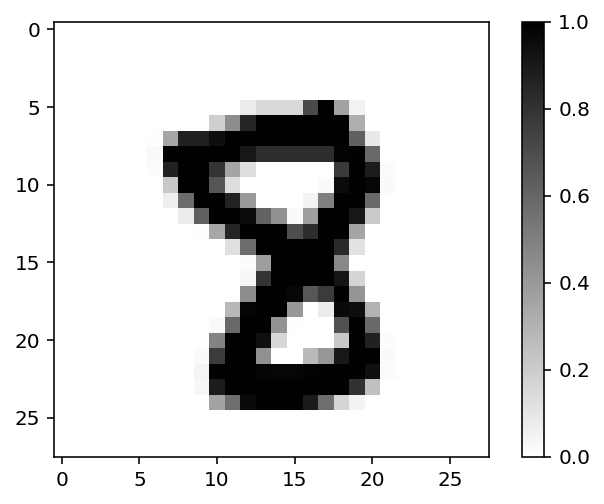

The label of this image is: 8


In [11]:
# Take a single batch of images, and remove the color dimension by squeezing it
for image_batch, label_batch in training_batches.take(1):
    # agin we need to convert images and labels to numpy to be able to plot them. here the size of images in (64,28,28,1)
    # by squeezing we omit 1 but we still have 64 images
    images = image_batch.numpy().squeeze() 
    labels = label_batch.numpy()

# Plot the image
# so we choose one image from 64 images by image[0]
plt.imshow(images[0], cmap = plt.cm.binary) 
# but here in training_batches has 64 images so we need select only one of them images[0]
plt.colorbar()
plt.show()

print('The label of this image is:', labels[0])
# as you can see here the plot x axis and y axis is go from 0 to 28 here like traininset but
# the gray scale here is between 0 to 1 in contrast to gray scale in training set which was from 0 to 255

## Build a Simple Neural Network

First, let's try to build a simple network for this dataset using weight matrices and matrix multiplications, just like we did in the previous notebook. Then, we'll see how to do it using TensorFlow and Keras, which provides a much more convenient and powerful method for defining network architectures.

The networks you've seen so far are called *fully-connected* or *dense* networks. Each unit in one layer is connected to each unit in the next layer. In fully-connected networks, the input to each layer must be a one-dimensional vector (which can be stacked into a 2D tensor as a batch of multiple examples). However, our images are 28 $\times$ 28 2D tensors, so we need to convert them into 1D vectors. Thinking about sizes, we need to convert the batch of images with shape `(64, 28, 28, 1)` to a have a shape of `(64, 784)`, 784 is 28 times 28. This is typically called *flattening*, we flattened the 2D images into 1D vectors.

In the previous notebook, you built a network with one output unit. Here we need 10 output units, one for each digit. We want our network to predict the digit shown in an image, so what we'll do, is calculate the probabilities that the image is of any one digit or class. This ends up being a discrete probability distribution over the classes (digits) that tells us the most likely class for the image. That means we need 10 output units for the 10 classes (digits). We'll see how to convert the network output into a probability distribution next.

> **Exercise:** Flatten the batch of images `images` that we've created above. Then build a simple network with 784 input units, 256 hidden units, and 10 output units using random tensors for the weights and biases. For now, use a sigmoid activation function for the units in the hidden layer. Leave the output layer without an activation, we'll add one that gives us a probability distribution next. **HINT:** You can use the [`tf.reshape()`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/reshape) function to flatten the batch of images.

In [12]:
## Solution
def activation(x):
    """ Sigmoid activation function
    
        Arguments
        ---------
        x: tf.Tensor. Must be one of the following types: bfloat16, half, float32, float64, complex64, complex128.
    """
    return 1/(1+tf.exp(-x))

# Flatten the input images
# if you remembere in the previous part we change the images from tesnor of (64,28,28,1) to numpy array (64,28,28)
# here we want to flatten the numpy array but we wnat to keep the number of batches 64 so for the first diemsnion 
# we say images.shape[0] and for the second dimension we say -1. this -1 tell multiply the left dimension. so here we define 
# the firts dimesnion as 64 and still we need to define the other dimesnion so this -1 tell the algoritm to do so
# 28* 28=784
inputs = tf.reshape(images, [images.shape[0], -1])

# Print the shape of the inputs. Should be (64,784)
print('The inputs have shape:', inputs.shape)

# Create Neural Network parameters
w1 = tf.random.normal((784,256))
b1 = tf.random.normal((1,256))

w2 = tf.random.normal((256,10))
b2 = tf.random.normal((1,10))

# Perform matrix multiplications for the hidden layer
# and apply activation function
h = activation(tf.matmul(inputs, w1) + b1)

# Perform matrix multiplication for the output layer
output = tf.matmul(h, w2) + b2

# Print the shape of the output. It should be (64,10)
print('The output has shape:', output.shape)

The inputs have shape: (64, 784)
The output has shape: (64, 10)


Now we have 10 outputs for our network. We want to pass in an image to our network and get out a probability distribution over the classes that tells us the most likely class(es) the image belongs to. Something that looks like this:
<img src='assets/image_distribution.png' width=500px>

Here we see that the probability for each class is roughly the same. This is representing an untrained network, it hasn't seen any data yet so it just returns a uniform distribution with equal probabilities for each class.

To calculate this probability distribution, we often use the [**softmax** function](https://en.wikipedia.org/wiki/Softmax_function). Mathematically this looks like

$$
\Large \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$

What this does is squish each input $x_i$ between 0 and 1 and normalizes the values to give you a proper probability distribution where the probabilities sum up to one.

> **Exercise:** Implement a function `softmax` that performs the softmax calculation and returns probability distributions for each example in the batch. Note that you'll need to pay attention to the shapes when doing this. If you have a tensor `a` with shape `(64, 10)` and a tensor `b` with shape `(64,)`, doing `a/b` will give you an error because TensorFlow will try to do the division across the columns (called broadcasting) but you'll get a size mismatch. The way to think about this is the following: for each of the 64 examples, you only want to divide by one value, the sum in the denominator. So you need `b` to have a shape of `(64, 1)`. This way TensorFlow will divide the 10 values in each row of `a` by the one value in each row of `b`. Pay attention to how you take the sum as well. You'll need to define the `axis` keyword in `tf.reduce_sum()`. Setting `axis=0` takes the sum across the rows while `axis=1` takes the sum across the columns. You will also need to use the `keepdims` keyword in `tf.reduce_sum()` to make sure the output tensor has the correct shape `(64,1)`.

In [13]:
## Solution
def activation(x):
    """ Sigmoid activation function
    
        Arguments
        ---------
        x: tf.Tensor. Must be one of the following types: bfloat16, half, float32, float64, complex64, complex128.
    """
    return 1/(1+tf.exp(-x))

inputs = tf.reshape(images, [images.shape[0], -1])

# Print the shape of the inputs. Should be (64,784)
print('The inputs have shape:', inputs.shape)

# Create Neural Network parameters
w1 = tf.random.normal((784,256))
b1 = tf.random.normal((1,256))

w2 = tf.random.normal((256,10))
b2 = tf.random.normal((1,10))

# Perform matrix multiplications for the hidden layer
# and apply activation function
h = activation(tf.matmul(inputs, w1) + b1)

# Perform matrix multiplication for the output layer
output = tf.matmul(h, w2) + b2

# Print the shape of the output. It should be (64,10)
print('The output has shape:', output.shape)

def softmax(x):
     
    return tf.exp(x) / tf.reduce_sum(tf.exp(x), axis=1, keepdims=True)

# Apply softmax to the output
probabilities = softmax(output)

# Print the shape of the probabilities. Should be (64, 10).
print('The probabilities have shape:', probabilities.shape, '\n')


# The sum of probabilities for each of the 64 images should be 1
# here we sum up the probability of each row in the matrix of 64*10 . it means we wnat to sum up the probability for each image
# that should all sum up to one. for xample image 1 show the probability 0.01 for class 0 show the probability 0.02 for class 1
# and so on so forth
sum_all_prob = tf.reduce_sum(probabilities, axis = 1).numpy() 

# Print the sum of the probabilities for each image.
for i, prob_sum in enumerate(sum_all_prob):
    print('Sum of probabilities for Image {}: {:.1f}'.format(i+1, prob_sum))

The inputs have shape: (64, 784)
The output has shape: (64, 10)
The probabilities have shape: (64, 10) 

Sum of probabilities for Image 1: 1.0
Sum of probabilities for Image 2: 1.0
Sum of probabilities for Image 3: 1.0
Sum of probabilities for Image 4: 1.0
Sum of probabilities for Image 5: 1.0
Sum of probabilities for Image 6: 1.0
Sum of probabilities for Image 7: 1.0
Sum of probabilities for Image 8: 1.0
Sum of probabilities for Image 9: 1.0
Sum of probabilities for Image 10: 1.0
Sum of probabilities for Image 11: 1.0
Sum of probabilities for Image 12: 1.0
Sum of probabilities for Image 13: 1.0
Sum of probabilities for Image 14: 1.0
Sum of probabilities for Image 15: 1.0
Sum of probabilities for Image 16: 1.0
Sum of probabilities for Image 17: 1.0
Sum of probabilities for Image 18: 1.0
Sum of probabilities for Image 19: 1.0
Sum of probabilities for Image 20: 1.0
Sum of probabilities for Image 21: 1.0
Sum of probabilities for Image 22: 1.0
Sum of probabilities for Image 23: 1.0
Sum of 

## Building Neural Networks with TensorFlow and Keras

Keras is a high-level API to build and train neural networks. `tf.keras` is TensorFlow's implementation of the Keras API. In Keras, deep learning models are constructed by connecting configurable building blocks called **layers**. The most common type of model is a stack of layers called a **Sequential** model. The model is called sequential because it allows a tensor to be passed sequentially through the operations in each layer. In TensorFlow, the sequential model is implemented with `tf.keras.Sequential`. 

In the cell below, we will use a Keras sequential model to build the same fully-connected neural network that we built in the previous section. Our sequential model will have three layers:

* **Input Layer:** `tf.keras.layers.Flatten` — This layer flattens the images by transforming a 2d-array of 28 $\times$ 28 pixels, to a 1d-array of 784 pixels (28 $\times$ 28 = 784). The first layer in a Sequential model needs to know the shape of the input tensors to the model. Since, this is our first layer, we need to specify the shape of our input tensors using the `input_shape` argument. The `input_shape` is specified using a tuple that contains the size of our images and the number of color channels. It is important to note that we don't have to include the batch size in the tuple. The tuple can have integers or `None` entries, where `None` entries indicate that any positive integer may be expected.

* **Hidden Layer:** `tf.keras.layers.Dense` — A fully-connected (also known as densely connected) layer. For this layer we need to specify the number of neurons (or nodes) we want to use and the activation function. Note that we don't have to specify the shape of the input tensor to this layer, since Keras performs automatic shape inference for all layers except for the first layer. In this particular case, we are going to use `256` neurons with a `sigmoid` activation fucntion. 

* **Output Layer:** `tf.keras.layers.Dense` — A fully-connected layer with 10 neurons and a *softmax* activation function. The output values will represent the probability that the image is a particular digit. The sum of all the 10 nodes values is 1.

In [10]:
'''
we need to specify the input dimension for the first layer in the Sequential model by a tuple of 
size of the image and color channels. input-shape(28,28,1) 28*28 is the size of image and 1 
is the color channel because we have only gray scale here the color channel is 1
'''
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape = (28,28,1)),  
    # only for the first layer in Sequential model we need to mention 
    # the number of inputs
    # this flatten layer flat the image by itself so we do not to be worry 
    # about flattening the image
    
        tf.keras.layers.Dense(256, activation = 'sigmoid'),
    # for other layers we do not need to mention the number of layers but 
    # we need to mention the number of nodes and type of activation function
        tf.keras.layers.Dense(10, activation = 'softmax')
])
# we can use .summary() method to get some information about our model architucteure
model.summary()
'''
# it gives back us the model name, type of layers their shape and number of parameters in each layer
# the None in the output shape column shows that they can accept any batch size. we did not 
  define batch size here
# but it can accept any batch_size (the only things is batch size needs to be positive int)

# the collumn parameters refer to the number of weights and biases in each layer.

'''


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


'\n# it gives back us the model name, type of layers their shape and number of parameters in each layer\n# the None in the output shape column shows that they can accept any batch size. we did not \n  define batch size here\n# but it can accept any batch_size (the only things is batch size needs to be positive int)\n\n# the collumn parameters refer to the number of weights and biases in each layer.\n\n'

 I like to make a note hear that when we make or use Sequential model it is not really flexiable.
 there are other ways to make the model more flexible.

### Your Turn to Build a Neural Network

<img src="assets/mlp_mnist.png" width=600px>

> **Exercise:** Create a network with 784 input units, a hidden layer with 128 units and a ReLU activation, then a hidden layer with 64 units and a ReLU activation, and finally an output layer with 10 units and a softmax activation function. You can use a ReLU activation function by setting `activation = 'relu'`.

In [11]:
## Solution
my_model_1 = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape = (28,28,1)), # i think i can give input like this too
                                                          # input_shape(None, 784) 
                                                          # None is the number of batch size and 
                                                          # it can be any positive int
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
])

my_model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


## Activation Functions

So far we've only been looking at the softmax activation, but in general any function can be used as an activation function. The only requirement is that for a network to approximate a non-linear function, the activation functions must be non-linear. Here are a few more examples of common activation functions: Tanh (hyperbolic tangent), and ReLU (rectified linear unit).

<img src="assets/activation.png" width=700px>

In practice, the ReLU function is used almost exclusively as the activation function for hidden layers.

## Looking at the Weights and Biases

Keras automatically initializes the weights and biases. The weights and biases are tensors attached to each of the layers you defined in your model. We can get all the weights and biases from our model by using the `get_weights` method. The `get_weights` method returns a list of all the weight and bias tensors in our model as NumPy arrays.

In [12]:
model_weights_biases = model.get_weights()

print(type(model_weights_biases))

<class 'list'>


In [13]:
print('\nThere are {:,} NumPy ndarrays in our list\n'.format(len(model_weights_biases)))

print(model_weights_biases)


There are 4 NumPy ndarrays in our list

[array([[-0.07028517,  0.0327006 , -0.05877179, ...,  0.01565402,
        -0.03827714, -0.0358993 ],
       [ 0.05164647,  0.05867982,  0.05247805, ..., -0.03058749,
        -0.04352426, -0.04753179],
       [ 0.04727201,  0.0189921 ,  0.04550977, ..., -0.02803764,
         0.05493213,  0.06499684],
       ...,
       [-0.04132365,  0.06593324,  0.05790102, ...,  0.02071945,
        -0.02768209, -0.03924359],
       [ 0.03892247,  0.05988269, -0.00835028, ...,  0.06721628,
        -0.06944962, -0.04185873],
       [ 0.02418979, -0.02826892, -0.04126818, ..., -0.05969945,
         0.0744254 , -0.00570559]], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.

We can also get the weights and biases for a specific layer by using the `get_layer` method. In this case we first specify the layer we want by using the `index` argument and the apply the `get_weights` method as we did before. For example, to get the weights and biases of the first layer of our sequential model we will use:
index define which layer. here index=0 shows first layer

```python
weights = model.get_layer(index=0).get_weights()[0]
biases = model.get_layer(index=0).get_weights()[1]

```

Notice, that we used `index=0` to get the first layer of our model which in this case is a `tf.keras.layers.Flatten`. Since this layer just flattens our input, it has no weights or biases. Therefore, in this case, the layer with `index=0` has no weights or biases, so calling `get_weights()[0]` will produce an error because  `get_weights()` will return an empty list (`[]`). So, when you are getting the weights and biases from each layer you should check first whether the layer has any weights or biases at all. 

Alternatively, you can also use the `layers` method to get a list of the layers of your model. You can then loop through the layers and check if they have weights before calling `get_weights()`. Let's see an example:

In [14]:
# Dislay the layers in our model
model.layers

In [15]:
model.

In [19]:
for i, layer in enumerate(model.layers):
    
    if len(layer.get_weights()) > 0:
        w = layer.get_weights()[0]
        b = layer.get_weights()[1]
        
        print('\nLayer {}: {}\n'.format(i, layer.name))
        print('\u2022 Weights:\n', w)
        print('\n\u2022 Biases:\n', b)
        print('\nThis layer has a total of {:,} weights and {:,} biases'.format(w.size, b.size))
        print('\n------------------------')
    
    else:
        print('\nLayer {}: {}\n'.format(i, layer.name))
        print('This layer has no weights or biases.')
        print('\n------------------------')


Layer 0: flatten

This layer has no weights or biases.

------------------------

Layer 1: dense

• Weights:
 [[ 0.05224116  0.06571884 -0.04375715 ...  0.02187659  0.04687703
   0.03914039]
 [ 0.05805588 -0.03016243  0.06498681 ...  0.00293887  0.01537188
  -0.03088053]
 [-0.0175484   0.05299486 -0.05896376 ... -0.05301232  0.05598871
   0.0562644 ]
 ...
 [-0.0278205  -0.02363378  0.03063794 ...  0.06159528  0.01429632
   0.05626869]
 [ 0.0559631  -0.05457924 -0.05597868 ... -0.0731673   0.05408156
  -0.037999  ]
 [ 0.02459992  0.06444438  0.06747225 ...  0.06128664 -0.06186411
   0.07071055]]

• Biases:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0

As we can see, by default, all the biases are initialized to zero.

On the other hand, by default, the weights are initialized using a Glorot uniform initializer that draws samples from a uniform distribution within \[-`limit`, `limit`\] where `limit` is `sqrt(6 / (fan_in + fan_out))` where `fan_in` is the number of input units in the weight tensor and `fan_out` is the number of output units in the weight tensor.

In Keras, you can change the default initialization methods for the weights and biases. To know more about the available initializers check out the links below:

* [Available initializers](https://keras.io/initializers/)

* [Dense Layer](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Dense)

## Make Predictions

To make predictions on a batch of images with our model we use the `.predict(image_batch)` method. This method takes the images in our batch, feeds them to our network, performs a forward pass, and outputs a NumPy ndarray of shape `(batch_size, num_classes)` with the predicted probabilities for each image in the batch. 

Since we have 64 images per batch (*i.e.* `batch_size = 64`) and our dataset has 10 classes (*i.e.* `num_classes = 10`), then our model will output an array of shape `(64,10)`. The rows in this array hold the predicted probabilities for our images. Consequently, the first row holds the predicted probabilities for the first image in our batch; the second row holds the predicted probabilities for the second image in our batch; the third row holds the predicted probabilities for the third image in our batch; and so on. In this case, the predicted probabilities consist of 10 values, that is, one probability per class. Therefore, for each of the 64 images in our batch we will have 10 probabilities. 

Let's plot our model's predicted probabilities for the first image in our batch.

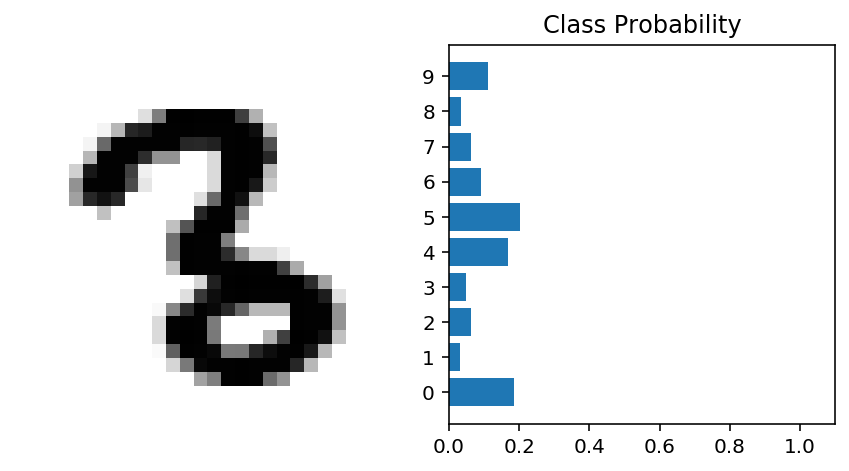

In [20]:
for image_batch, label_batch in training_batches.take(1):
    ps = model.predict(image_batch) # ps contain the probability for each image in the batch since we 64 images then we have
                                    # (64,10) dimension for ps
    first_image = image_batch.numpy().squeeze()[0]


fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(first_image, cmap = plt.cm.binary)
ax1.axis('off')
ax2.barh(np.arange(10), ps[0]) # we use ps[0] to see the prdicited probability only for the first image in the batch
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()
# as you can see we could not find good probability for the image since we have not traind our data yet.

As you can see above, our model gives every digit roughly the same probability. This means our network has basically no idea what the digit in the image is. This is because we haven't trained our model yet, so all the weights are random!

The Keras Python library makes creating deep learning models fast and easy.

The sequential API allows you to create models layer-by-layer for most problems. It is limited in that it does not allow you to create models that share layers or have multiple inputs or outputs.

The functional API in Keras is an alternate way of creating models that offers a lot more flexibility, including creating more complex models.

In this tutorial, you will discover how to use the more flexible functional API in Keras to define deep learning models.

After completing this tutorial, you will know:

The difference between the Sequential and Functional APIs.
How to define simple Multilayer Perceptron, Convolutional Neural Network, and Recurrent Neural Network models using the functional API.
How to define more complex models with shared layers and multiple inputs and outputs.

click the link to have full description of functional API keras
https://machinelearningmastery.com/keras-functional-api-deep-learning/


## Subclassing with TensorFlow and Keras

The `tf.keras.Sequential` model is a simple stack of layers that cannot be used to create arbitrary models. Luckily, `tf.keras` gives us the flexibility to build fully-customizable models by subclassing the `tf.keras.Model` and defining our own forward pass.

In the following example we will use a subclassed `tf.keras.Model` to build the same neural network as we built above with 784 inputs, 256 hidden units, and 10 output units. As before, we will use a ReLu activation function for the units in the hidden layer, and a Softmax activation function for the output neurons. 

In [28]:
 #here our class 'Network' inherit form 'tf.keras.Model' class. we can call our class whatever we want
class Network(tf.keras.Model):
    def __init__(self, num_classes = 2): # this 'num_classes = 2' define the number of unit in our output layer and we can change it
        super().__init__()
        self.num_classes = num_classes
    
        # Define layers 
        # we need to define specific name for each layer
        self.input_layer = tf.keras.layers.Flatten() # we do not need to specifiy the shape of input in the first layer here
                                                     # but we need to define it later.
        self.hidden_layer = tf.keras.layers.Dense(256, activation = 'relu')
        self.output_layer = tf.keras.layers.Dense(self.num_classes, activation = 'softmax')
    
    # Define forward Pass
    # the call method is where really the Sequential and Subclass method are different.
    # this call method alow Subclassing being fully costumizable models
    # in the call method we can specifiy all the opearion we want and the order of them like: 
    #we can do any operation on our 
    #'input-tensor'
    # at any point. like below: we can multiply the output of hidden layer by two before feeding it to next layer
    #     def call(self, input_tensor):
    #    x = self.input_layer(input_tensor)
    #   x = self.hidden_layer(x)
    #   x=x*2
    #   x = self.output_layer(x)
    # so the possibility is endless and you can try as much operation as you like in the call method.
    
        
    
    def call(self, input_tensor):
        x = self.input_layer(input_tensor)
        x = self.hidden_layer(x)
        x = self.output_layer(x)
    
        return x 

Let's go through this bit by bit.

```python
class Network(tf.keras.Model):
```

Here we're inheriting from `tf.keras.Model`. Combined with `super().__init__()` this creates a class that provides a lot of useful methods and attributes. It is mandatory to inherit from `tf.keras.Model` when you're creating a class for your network. However, the name of the class itself can be anything.

We then create the layers of our network in the `__init__` method and set them as attributes of the class instance. We also assign the number of neurons in our output layer in the `__init__` method via the `num_classes` argument, which by default will have a value of 2.

```python
self.input = tf.keras.layers.Flatten()
```

The first layer flattens the input image as we have discussed previously. We have given this layer the name `self.input`. We will use this name to reference this layer later. It doesn't matter what name you give your layers, you can name them whatever you want.

```python
self.hidden = tf.keras.layers.Dense(256, activation = 'relu')
```

The second layer is a fully-connected (dense) layer with 256 neurons and a ReLu activation function. We have given this layer the name `self.hidden`. We will use this name to reference this layer later.

```python
self.output = tf.keras.layers.Dense(self.num_classes, activation = 'softmax')
```

The third and last layer (output layer) is also a fully-connected (dense) layer with `self.num_classes` neurons and a softmax activation function. By default the number of output units will be 2, but can be defined to be any other integer depending on the number of output classes of your dataset. 

Next, we define the forward pass in the `call` method.

```python
def call(self, input_tensor):
```

TensorFlow models created with `tf.keras.Model` must have a `call` method defined. In the `call` method we take `input_tensor` and pass it through the layers we defined in the `__init__` method.

```python
x = self.input(input_tensor)
x = self.hidden(x)
x = self.output(x)
```

Here the `input_tensor` is passed through each layer and reassigned to `x`. We can see that the `input_tensor` goes through the `input` layer, then the `hidden` layer, and finally through the `output` layer. The order in which you define the layers in the `__init__` method doesn't matter, but you'll need to sequence the layers correctly in the `call` method. Notice that we are referring to each layer in the `__init__` method by the name we gave them. Remember this names are arbitrary.

Now that we have defined our model class we can create a `model` object. Note that we didn't specify the shape of our input tensor in our `Network` class. In this case, the weights and biases will only be initialized when we build our model by calling `build(batch_input_shape)` or when the first call to a training/evaluation method (such as `.fit` or `.evaluate`) is made. We call this a delayed-build pattern.

So, now let's create a `model` object and build it (i.e. initialize its weights and biases) by calling `build()`.

In [29]:
# Create a model object
# since in this MNIST dataset we have 10 classes we put 10 here
# here we still do not have any weights and biases since we do not provide any input_tensor
subclassed_model = Network(10) 

# Build the model, i.e. initialize the model's weights and biases
# we need to build the model by giving the input_tesor. so then we can have weights and biases
# this None shows that accept batches of any size and we do not need to define the batch size in advance
subclassed_model.build((None, 28, 28, 1))

# print out our model summary
subclassed_model.summary()

Model: "network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          multiple                  0         
_________________________________________________________________
dense_8 (Dense)              multiple                  200960    
_________________________________________________________________
dense_9 (Dense)              multiple                  2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


Remember that `None` is used to indicate that any integer may be expected. So, we use `None` to indicate batches of any size are acceptable. 

While model subclassing offers flexibility, it comes at a cost of greater complexity and more opportunities for
user errors. So, we recommend, to always use the simplest tool for the job. 

### Your Turn to Build a Neural Network

<img src="assets/mlp_mnist.png" width=600px>

> **Exercise:** Use the subclassing method to create a network with 784 input units, a hidden layer with 128 units and a ReLU activation, then a hidden layer with 64 units and a ReLU activation, and finally an output layer with 10 units and a softmax activation function. You can use a ReLU activation function by setting `activation = 'relu'`. After you create your model, create a model object and build it.

In [30]:
## Solution
class SubModel(tf.keras.Model):
    def __init__(self, num_classes = 10):
        super().__init__()
        self.num_classes = num_classes
    
        # Define layers 
        self.input_layer = tf.keras.layers.Flatten()
        self.hidden_layer_1 = tf.keras.layers.Dense(128, activation = 'relu')
        self.hidden_layer_2 = tf.keras.layers.Dense(64, activation = 'relu')
        self.output_layer = tf.keras.layers.Dense(self.num_classes, activation = 'softmax')
    
    # Define forward Pass   
    def call(self, input_tensor):
        x = self.input_layer(input_tensor)
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.output_layer(x)
    
        return x 

my_model_2 = SubModel(10)
my_model_2.build((None, 28, 28, 1))

my_model_2.summary()

Model: "sub_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          multiple                  0         
_________________________________________________________________
dense_10 (Dense)             multiple                  100480    
_________________________________________________________________
dense_11 (Dense)             multiple                  8256      
_________________________________________________________________
dense_12 (Dense)             multiple                  650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


## Looking at Weights and Biases of Subclassed Models

As before, we can get the weights an biases of each layer in our subclassed models. In this case, we can use the name we gave to each layer in the `__init__` method to get the weights and biases of a particular layer. For example, in the exercise we gave the first hidden layer the name `hidden_1`, so we can get the weights an biases from this layer by using:

In [31]:
w1 = my_model_2.hidden_layer_1.get_weights()[0] # getting weight numpy array
b1 = my_model_2.hidden_layer_1.get_weights()[1] # getting bias numpy array

print('\n\u2022 Weights:\n', w)
print('\n\u2022 Biases:\n', b)
print('\nThis layer has a total of {:,} weights and {:,} biases'.format(w1.size, b1.size))


• Weights:
 [[ 0.02185465 -0.05030233 -0.1368684  ... -0.00501524  0.07895398
   0.08419384]
 [-0.05298693  0.09776023 -0.09744956 ...  0.0623804   0.08589235
   0.06363741]
 [-0.08758185  0.01470761  0.01309179 ...  0.04968333 -0.1081176
  -0.0717071 ]
 ...
 [ 0.05959898 -0.06248511 -0.01243587 ... -0.05505529  0.10256878
  -0.1342663 ]
 [ 0.02986807 -0.07544731 -0.09657618 ...  0.04134127  0.04379578
  -0.018751  ]
 [-0.13206592  0.07676896  0.09197329 ...  0.02362734 -0.1323594
   0.09826794]]

• Biases:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

This layer has a total of 100,352 weights and 128 biases


All the other methods we saw before, such as `.layers`, are also available for subclassed models, so feel free to use them.

## Making Predictions with Subclassed Models

Predictions are made in exactly the same way as before. So let's pass an image to our subclassed model and see what we get:

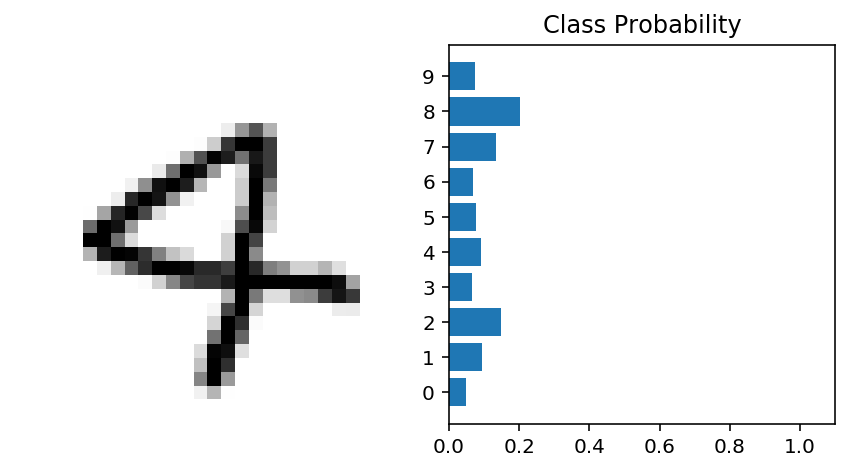

In [32]:
for image_batch, label_batch in training_batches.take(1):
    ps = subclassed_model.predict(image_batch)
    first_image = image_batch.numpy().squeeze()[0]

fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(first_image, cmap = plt.cm.binary)
ax1.axis('off')
ax2.barh(np.arange(10), ps[0])
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()

As before, we can see above, our model gives every digit roughly the same probability. This means our network has basically no idea what the digit in the image is. This is because we haven't trained our model yet, so all the weights are random!

In the next notebook, we'll see how we can train a neural network to accurately predict the numbers appearing in the MNIST images.

## Other Methods to Create Models

In [33]:
# we create a sequential model without any layers
model = tf.keras.Sequential()

# we can add layers by using add method.

model.add(tf.keras.layers.Flatten(input_shape = (28,28,1)))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
          
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_14 (Dense)             (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [34]:
# list number of neurons in each six hidden layer.
layer_neurons = [512, 256, 128, 56, 28, 14]

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape = (28,28,1)))

for neurons in layer_neurons:
    model.add(tf.keras.layers.Dense(neurons, activation='relu'))
            
model.add(tf.keras.layers.Dense(10, activation='softmax'))
          
model.summary()        

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_18 (Dense)             (None, 56)                7224      
_________________________________________________________________
dense_19 (Dense)             (None, 28)                1596      
_________________________________________________________________
dense_20 (Dense)             (None, 14)               

## Clearing the Graph

In order to avoid clutter from old models in the graph, we can use:

```python
tf.keras.backend.clear_session()
```

This command deletes the current `tf.keras` graph and creates a new one.

In [35]:
tf.keras.backend.clear_session()

layer_neurons = [512, 256, 128, 56, 28, 14]

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape = (28,28,1)))

for neurons in layer_neurons:
    model.add(tf.keras.layers.Dense(neurons, activation='relu'))
            
model.add(tf.keras.layers.Dense(10, activation='softmax'))
          
model.summary()    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 56)                7224      
_________________________________________________________________
dense_4 (Dense)              (None, 28)                1596      
_________________________________________________________________
dense_5 (Dense)              (None, 14)                4